In [1]:
import os
import math
import string

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.data import Field, BucketIterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
import fasttext
import sklearn

import models
from trtokenizer.tr_tokenizer import SentenceTokenizer, WordTokenizer

import unicodedata
import re

In [2]:
from torchtext.legacy.datasets import Multi30k

In [3]:
"""
news_df = pd.read_csv('dataframes/wmt-news.csv')
news_df = news_df.drop('partition', axis = 1)
news_df.en = news_df.en.apply(lambda x: str(x).replace('\n', ''))
news_df.tr = news_df.tr.apply(lambda x: str(x).replace('\n', ''))
news_df

train_val_df = news_df.sample(9000, random_state = 7)
test_df = news_df[~news_df.index.isin(train_val_df.index)]

train_df = train_val_df.sample(8500, random_state = 7)
valid_df = train_val_df[~train_val_df.index.isin(train_df.index)]

len(train_df), len(valid_df), len(test_df)

iwslt_df = pd.read_csv('dataframes/iwslt14.csv')

iwslt_train_val_df = iwslt_df.sample(2000, random_state = 7)
iwslt_test_df = iwslt_df[~iwslt_df.index.isin(iwslt_train_val_df.index)]

iwslt_train_df = iwslt_train_val_df.sample(1500, random_state = 7)
iwslt_valid_df = iwslt_train_val_df[~iwslt_train_val_df.index.isin(iwslt_train_df.index)]

len(iwslt_train_df), len(iwslt_valid_df), len(iwslt_test_df)

train_df['split'] = 'train'
valid_df['split'] = 'validation'
test_df['split']  = 'test'

iwslt_train_df['split'] = 'train'
iwslt_valid_df['split'] = 'validation'
iwslt_test_df['split'] = 'test'

df = pd.concat([train_df, valid_df, test_df, iwslt_train_df, iwslt_valid_df, iwslt_test_df])
df = df.reset_index(drop= True)
df.to_csv('dataframes/combined-iwslt-news.csv')
""";

"""
df = pd.read_csv(os.path.join('dataframes', 'wmt16.csv'))
df.split.unique()

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

with open('en-fr-data/eng-fra.txt') as f:
    lines = f.read().strip().split('\n')
    lines = [line.split('\t') for line in lines]

train, test = sklearn.model_selection.train_test_split(lines, test_size = 0.1, train_size = 0.9)
train, valid = sklearn.model_selection.train_test_split(train, test_size = 0.1, train_size = 0.9)

en_samples = []
fr_samples = []

for sample in test:
    en, fr = sample

    en = normalizeString(en)
    fr = normalizeString(fr)

    en_samples.append(en)
    fr_samples.append(fr)

def create_df(en_samples, fr_samples, split:str):
    train_df = pd.DataFrame({'en': [], 'fr': [], 'split': []})

    train_df.en = en_samples
    train_df.fr = fr_samples
    train_df.split = split
    return train_df

train_df = create_df(en_samples, fr_samples, 'train')

valid_df = create_df(en_samples, fr_samples, 'validation')

test_df = create_df(en_samples, fr_samples, 'test')

pd.concat([train_df, valid_df, test_df]).reset_index(drop = True).to_csv('en_fr.csv')
""";

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def save_checkpoint(model, optimizer, loss, epoch, path):
    checkpoint = {
        "epoch" : epoch,
        "loss" : loss,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
    }

    torch.save(checkpoint, path)

def load_checkpoint(model, path):
    checkpoint = torch.load(path, map_location = device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)

    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]

    return epoch, loss

## Train Definitions

In [6]:
MAX_EPOCH  = 200
MAX_TOKEN_LEN = 90
BATCH_SIZE = 32
INITIAL_LR = 0.0005
MODEL_TYPE = 'transformer'

CLIP = 5 # ??
TRAIN = True

## Data Definitions

In [7]:
DATAFRAME_PATH = './dataframes'

In [8]:
tr_word_tokenizer = WordTokenizer()

def en_tokenizer(text: str) -> list:
    return nltk.word_tokenize(text, language = 'english')[: MAX_TOKEN_LEN]

def tr_tokenizer(text: str) -> list:
    return tr_word_tokenizer.tokenize(text)[: MAX_TOKEN_LEN]

def fr_tokenizer(text: str) -> list:
    return nltk.word_tokenize(text, language = 'french')

def de_tokenizer(text: str) -> list:
    return nltk.word_tokenize(text, language = 'german')[: MAX_TOKEN_LEN]

In [20]:
df = pd.read_csv(os.path.join(DATAFRAME_PATH, 'root-iwslt14_.csv'))

train_df = df[df.split == 'train']
valid_df = df[df.split == 'validation']

valid_df = valid_df.reset_index(drop = True)
train_df = train_df.reset_index(drop = True)

In [21]:
wmt_df = pd.read_csv(os.path.join(DATAFRAME_PATH, 'wmt16.csv'))
wmt_train = wmt_df[wmt_df.split == 'train']

wmt_train = wmt_train[wmt_train.tr.apply(lambda x: len(x.split()) < 40)]
wmt_train = wmt_train.reset_index(drop = True)
#wmt_train = wmt_train.sample(10000, random_state = 7)

In [11]:
#train_df = pd.concat([train_df, wmt_train]).reset_index(drop = True)

### Build Vocabulary

In [22]:
class NMTDataset(Dataset):
    def __init__(self, en_series, tr_series, en_vocab, tr_vocab):
        self.en_series = en_series
        self.tr_series = tr_series
        self.en_vocab = en_vocab
        self.tr_vocab = tr_vocab

        assert len(en_series) == len(tr_series)
        self.ds_len = len(self.en_series)
        self.data = []

        self.convert_text_to_tokens()

    def __len__(self):
        return self.ds_len

    def __getitem__(self, indx):
        sample = self.data[indx]
        return {'src': sample[0], 'trg': sample[1]}

    def convert_text_to_tokens(self):
        for i in range(len(self.en_series)):
            en_tensor = torch.tensor([self.en_vocab[token] for token in self.en_series[i]], dtype = torch.long)
            tr_tensor = torch.tensor([self.tr_vocab[token] for token in self.tr_series[i]], dtype = torch.long)
            self.data.append((en_tensor, tr_tensor))

In [23]:
def apply_preprocess(x, field):
    def apply_token_replacement(token):
        return token.replace('.', '').replace(',', '').replace('“', '')

    out = field.preprocess(str(x))
    return [apply_token_replacement(token.lower()) for token in out]
    return [token.lower() for token in out]

In [24]:
def get_corpora_dataset(src_text: str, trg_text: str, src_vocab, trg_vocab):
    data = []

    for i in range(len(src_text)):
        src_tensor = torch.tensor([src_vocab[token] for token in src_text[i]], dtype = torch.long)
        trg_tensor = torch.tensor([trg_vocab[token] for token in trg_text[i]], dtype = torch.long)
        data.append((src_tensor, trg_tensor))

    return data

def generate_batch(data_batch):
    src_batch, trg_batch = [], []

    for (src_item, trg_item) in data_batch:
        src_batch.append(torch.cat([torch.tensor([SOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
        trg_batch.append(torch.cat([torch.tensor([SOS_IDX]), trg_item, torch.tensor([EOS_IDX])], dim=0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

In [25]:
def pad_batch(data_batch):
    src_batch, trg_batch = [], []

    for item in data_batch:
        src_item = item['src']
        trg_item = item['trg']

        src_batch.append(torch.cat([torch.tensor([SOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
        trg_batch.append(torch.cat([torch.tensor([SOS_IDX]), trg_item, torch.tensor([EOS_IDX])], dim=0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, trg_batch

In [26]:
if MODEL_TYPE == 'transformer':
    en_field = Field(tokenize = en_tokenizer, init_token='<sos>', eos_token='<eos>', batch_first = True)
    tr_field  = Field(tokenize = tr_tokenizer, init_token='<sos>', eos_token='<eos>', batch_first = True)
else:
    en_field = Field(tokenize = en_tokenizer, init_token='<sos>', eos_token='<eos>')
    tr_field  = Field(tokenize = tr_tokenizer, init_token='<sos>', eos_token='<eos>')

# get preprocessed train data
en_train_preprocessed_text = train_df['en'].apply(lambda x: apply_preprocess(x, en_field))
tr_train_preprocessed_text = train_df['tr'].apply(lambda x: apply_preprocess(x, tr_field))

# get preprocessed train data
en_valid_preprocessed_text = valid_df['en'].apply(lambda x: apply_preprocess(x, en_field))
tr_valid_preprocessed_text = valid_df['tr'].apply(lambda x: apply_preprocess(x, tr_field))

# build vocabulary for the languages
en_field.build_vocab(pd.concat([en_train_preprocessed_text, en_valid_preprocessed_text]), min_freq = 2)
tr_field.build_vocab(pd.concat([tr_train_preprocessed_text, tr_valid_preprocessed_text]), min_freq = 2)

# define src and target fields
SRC_FIELD = tr_field
TRG_FIELD = en_field

SRC_VOCAB = SRC_FIELD.vocab
TRG_VOCAB = TRG_FIELD.vocab

SRC_TRAIN_TEXT = tr_train_preprocessed_text
SRC_VALID_TEXT = tr_valid_preprocessed_text

TRG_TRAIN_TEXT = en_train_preprocessed_text
TRG_VALID_TEXT = en_valid_preprocessed_text

# define tags
# only taking values from tr since they are equal in en_vocab as well
PAD_IDX = TRG_VOCAB['<pad>']
SOS_IDX = TRG_VOCAB['<sos>']
EOS_IDX = TRG_VOCAB['<eos>']

In [27]:
"""
# DE-EN
SRC_FIELD = Field(tokenize = de_tokenizer, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG_FIELD = Field(tokenize = en_tokenizer, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC_FIELD, TRG_FIELD), )

SRC_FIELD.build_vocab(train_data, min_freq = 2)
TRG_FIELD.build_vocab(train_data, min_freq = 2)

SRC_VOCAB = SRC_FIELD.vocab
TRG_VOCAB = TRG_FIELD.vocab

# define tags
# only taking values from tr since they are equal in en_vocab as well
PAD_IDX = TRG_VOCAB['<pad>']
SOS_IDX = TRG_VOCAB['<sos>']
EOS_IDX = TRG_VOCAB['<eos>']

train_loader, valid_loader, test_loader = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device,
    shuffle = True)
""";

In [28]:
if TRAIN:
    """
    train_dataset = NMTDataset(en_train_preprocessed_text, tr_train_preprocessed_text, en_vocab, tr_vocab)
    valid_dataset = NMTDataset(en_valid_preprocessed_text, tr_valid_preprocessed_text, en_vocab, tr_vocab)

    train_loader = BucketIterator(train_dataset, batch_size = BATCH_SIZE, 
                                                        sort_key = (lambda x: (len(x['src']) + len(x['trg']))), 
                                                        repeat=True,  sort=False,  shuffle=True, 
                                                        sort_within_batch=True)

    valid_loader = BucketIterator(valid_dataset, batch_size = BATCH_SIZE, 
                                                        sort_key = (lambda x: (len(x['src']) + len(x['trg']))), 
                                                        repeat=True,  sort=False,  shuffle=False, 
                                                        sort_within_batch=True)
    """

    train_dataset = get_corpora_dataset(SRC_TRAIN_TEXT, TRG_TRAIN_TEXT, SRC_VOCAB, TRG_VOCAB)
    valid_dataset = get_corpora_dataset(SRC_VALID_TEXT, TRG_VALID_TEXT, SRC_VOCAB, TRG_VOCAB)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn = generate_batch)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = generate_batch)

In [29]:
len(SRC_VOCAB.itos[4:]), len(TRG_VOCAB.itos[4:])

(11821, 17388)

In [20]:
indx_ = 1

In [21]:
' '.join(en_train_preprocessed_text[indx_])

'kosovo is taking a hard look at its privatisation process in light of recurring complaints '

In [22]:
' '.join(tr_train_preprocessed_text[indx_])

'kosova  tekrar eden şikayetler ışığında özelleştirme sürecini incelemeye alıyor '

## Model Definitions

In [23]:
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

def initialize_transformer_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [24]:
INPUT_DIM = len(SRC_VOCAB)
OUTPUT_DIM = len(TRG_VOCAB)

# embedding hyperparams
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256

ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# model hyperparams
if MODEL_TYPE == 'attention':
    ENC_HID_DIM = 512
    DEC_HID_DIM = 512

    attn = models.Attention(ENC_HID_DIM, DEC_HID_DIM)
    enc  = models.AttentionEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec  = models.AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    model = models.AttentionSeq2Seq(enc, dec, device).to(device)

elif MODEL_TYPE == 'recurrent':
    HID_DIM = 1024
    N_LAYERS = 2

    enc = models.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = models.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = models.Seq2Seq(enc, dec, device).to(device)

    model.apply(xavier_init_weights)
elif MODEL_TYPE == 'transformer':
    ENC_LAYERS = 6
    DEC_LAYERS = 6

    ENC_HEADS = 8
    DEC_HEADS = 8

    ENC_PF_DIM = 512
    DEC_PF_DIM = 512

    enc = models.TransformerEncoder(INPUT_DIM, 
                  ENC_EMB_DIM, 
                  ENC_LAYERS, 
                  ENC_HEADS, 
                  ENC_PF_DIM, 
                  ENC_DROPOUT, 
                  device)

    dec = models.TransformerDecoder(OUTPUT_DIM, 
                  DEC_EMB_DIM, 
                  DEC_LAYERS, 
                  DEC_HEADS, 
                  DEC_PF_DIM, 
                  DEC_DROPOUT, 
                  device)

    SRC_PAD_IDX = SRC_VOCAB.stoi[SRC_FIELD.pad_token]
    TRG_PAD_IDX = TRG_VOCAB.stoi[TRG_FIELD.pad_token]

    model = models.TransformerSeq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [25]:
# loss function
TRG_PAD_IDX = TRG_VOCAB.stoi[TRG_FIELD.pad_token]
loss_fn = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

### Train & Eval Loop

In [26]:
# BLEU SCORE
from torchtext.data.metrics import bleu_score

def calculate_bleu(gt_trg, pred_trg):
    bleu_scores = 0
    batch_size = gt_trg.shape[1]
    for i in range(batch_size):
        gt_sentence   = gt_trg[:, i]
        pred_sentence = pred_trg[:, i, :]

        gt_sentence   = [tr_vocab.itos[token_id] for token_id in gt_sentence]
        # greedy decoding
        pred_sentence = [tr_vocab.itos[torch.argmax(output_distr)] for output_distr in pred_sentence]

        bleu_score = nltk.translate.bleu_score.sentence_bleu([gt_sentence], pred_sentence, weights = [0.5, 0.5])
        bleu_scores += bleu_score

    return bleu_scores / batch_size

In [27]:
if TRAIN:
    best_valid_loss = 999999
    plateau_counter = 0

    for epoch in range(MAX_EPOCH):
        #train_loader.create_batches()
        #valid_loader.create_batches()

        train_looper = tqdm(enumerate(train_loader), total=len(train_loader), leave = False, position = 0)
        train_looper.set_description("Epoch [{:003}]".format(epoch + 1))

        epoch_train_loss = 0
        epoch_valid_loss = 0
        train_bleu_score = 0
        valid_bleu_score = 0

        #train
        model.train()
        for i, (batch) in train_looper:
            src, trg = (batch)

            #src = batch.src
            #trg = batch.trg
            
            src = src.to(device)
            trg = trg.to(device)

            # for transformer
            #src = src.T
            #trg = trg.T

            optimizer.zero_grad()

            output = model(src, trg)

            # for transformer
            #output, _ = model(src, trg[:, :-1])

            # for transformer
            #output_dim = output.shape[-1]
            #output = output.contiguous().view(-1, output_dim)
            #trg = trg[:,1:].contiguous().view(-1)

            #bleu_score = calculate_bleu(trg, output)
            #train_bleu_score += bleu_score

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = loss_fn(output, trg)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            optimizer.step()
            epoch_train_loss += loss.item()
            train_looper.set_postfix(loss=loss.detach().item(), bleu = bleu_score, ppl= math.exp(loss))

        #evaluate
        model.eval()
        with torch.no_grad():
            for _, (batch) in enumerate(valid_loader):
                src, trg = (batch)
                #src = batch.src
                #trg = batch.trg

                src = src.to(device)
                trg = trg.to(device)

                #for transformer
                #src = src.T
                #trg = trg.T

                # for transformer
                #output, _ = model(src, trg[:,:-1])

                # for transformer
                #output_dim = output.shape[-1]
                #output = output.contiguous().view(-1, output_dim)
                #trg = trg[:,1:].contiguous().view(-1)

                output = model(src, trg, 0) #turn off teacher forcing

                #bleu_score = calculate_bleu(trg, output)
                #valid_bleu_score += bleu_score

                output = output[1:].view(-1, output.shape[-1])
                trg = trg[1:].view(-1)

                loss = loss_fn(output, trg)
                epoch_valid_loss += loss.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        train_bleu_score = train_bleu_score / len(train_loader)
        valid_bleu_score = valid_bleu_score / len(valid_loader)

        scheduler.step(epoch_valid_loss)

        print("Epoch: {}, TrainLoss: {:.2f}, ValidLoss : {:.2f}, TrainBleu: \
              {:2f}, ValidBleu: {:2f}, TrainPPL: {:2f}, ValidPPL: {:2f}, lr: {}".format(epoch + 1, epoch_train_loss, 
                                                      epoch_valid_loss, train_bleu_score, valid_bleu_score,
                                                      math.exp(epoch_train_loss), math.exp(epoch_valid_loss),
                                                      optimizer.param_groups[0]['lr']))    

        # checkpoint
        if epoch_valid_loss < best_valid_loss:
            #if True:
            plateau_counter = 0
            best_valid_loss = epoch_valid_loss
            checkpoint_path = '/media/dcl/7D03F77D0BDB12B9/HTR-Firat/Transformers/transformer-models/' + str(MODEL_TYPE) + "_model_{}.pkl".format(epoch + 1)
            print("Saving {} at EPOCH: {}".format(checkpoint_path, epoch + 1))
            save_checkpoint(model, optimizer, epoch_valid_loss, (epoch + 1), checkpoint_path)
        else:
            plateau_counter += 1
            if plateau_counter > 5:
                print("Early stopping...")
                break

Epoch: 1, TrainLoss: 4.11, ValidLoss : 4.38, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 60.902706, ValidPPL: 79.452147, lr: 0.0005
Saving /media/dcl/7D03F77D0BDB12B9/HTR-Firat/Transformers/transformer-models/attention_model_1.pkl at EPOCH: 1


Epoch: 2, TrainLoss: 2.00, ValidLoss : 3.91, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 7.413392, ValidPPL: 49.794713, lr: 0.0005
Saving /media/dcl/7D03F77D0BDB12B9/HTR-Firat/Transformers/transformer-models/attention_model_2.pkl at EPOCH: 2


Epoch: 3, TrainLoss: 1.60, ValidLoss : 3.81, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 4.945709, ValidPPL: 45.245805, lr: 0.0005
Saving /media/dcl/7D03F77D0BDB12B9/HTR-Firat/Transformers/transformer-models/attention_model_3.pkl at EPOCH: 3


Epoch: 4, TrainLoss: 1.38, ValidLoss : 3.83, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 3.981667, ValidPPL: 46.225042, lr: 0.0005


Epoch: 5, TrainLoss: 1.22, ValidLoss : 3.78, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 3.389035, ValidPPL: 43.807141, lr: 0.0005
Saving /media/dcl/7D03F77D0BDB12B9/HTR-Firat/Transformers/transformer-models/attention_model_5.pkl at EPOCH: 5


Epoch: 6, TrainLoss: 1.07, ValidLoss : 3.92, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 2.927397, ValidPPL: 50.400286, lr: 0.0005


Epoch: 7, TrainLoss: 0.96, ValidLoss : 3.91, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 2.604594, ValidPPL: 49.800334, lr: 0.0005


Epoch: 8, TrainLoss: 0.88, ValidLoss : 3.93, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 2.405798, ValidPPL: 50.669296, lr: 5e-05


Epoch: 9, TrainLoss: 0.76, ValidLoss : 3.88, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 2.139827, ValidPPL: 48.407006, lr: 5e-05


Epoch: 10, TrainLoss: 0.72, ValidLoss : 3.88, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 2.054408, ValidPPL: 48.204207, lr: 5e-05


Epoch: 11, TrainLoss: 0.69, ValidLoss : 3.87, TrainBleu:               0.000000, ValidBleu: 0.000000, TrainPPL: 1.995707, ValidPPL: 47.992401, lr: 5e-06
Early stopping...


## Evaluate

### Evaluate on Transformer

In [26]:
from torchtext.data.metrics import bleu_score

def rnn_calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    model.eval()

    trgs = []
    pred_trgs = []

    src_list, trg_list = data
    for i in range(len(src_list)):
        print(i)

        src = src_list[i]
        trg = trg_list[i]

        tokens = [src_field.init_token] + src + [src_field.eos_token]
        src_indexes = [src_field.vocab.stoi[token.lower()] for token in tokens]
        src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

        tokens = [trg_field.init_token] + trg + [trg_field.eos_token]
        trg_indexes = [trg_field.vocab.stoi[token.lower()] for token in tokens]
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        output = model(src_tensor, trg_tensor)

        output_len = output.shape[1]
        if output_len > max_len:
            output_len = max_len

        trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
        for j in range(output_len):
            out = output[0][j]
            # greedy
            pred_token = out.argmax().item()

            trg_indexes.append(pred_token)
            if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
                break

        pred_sentence = [trg_field.vocab.itos[i] for i in trg_indexes]

        trgs.append([trg])
        pred_trgs.append(pred_sentence)

    bleu1 = bleu_score(pred_trgs, trgs, weights = [1, 0, 0, 0])
    bleu2 = bleu_score(pred_trgs, trgs, weights = [0.5, 0.5, 0, 0])
    bleu3 = bleu_score(pred_trgs, trgs, weights = [0.33, 0.33, 0.33, 0])
    bleu4 = bleu_score(pred_trgs, trgs, weights = [0.25, 0.25, 0.25, 0.25])

    return [bleu1, bleu2, bleu3, bleu4]

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []

    src_list, trg_list = data
    for i in range(1, len(src_list)):
        print(i)

        src = src_list[i]
        trg = trg_list[i]

        #src = vars(src)
        #trg = vars(trg)

        pred_trg, _ = transformer_translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    bleu1 = bleu_score(pred_trgs, trgs, weights = [1, 0, 0, 0])
    bleu2 = bleu_score(pred_trgs, trgs, weights = [0.5, 0.5, 0, 0])
    bleu3 = bleu_score(pred_trgs, trgs, weights = [0.33, 0.33, 0.33, 0])
    bleu4 = bleu_score(pred_trgs, trgs, weights = [0.25, 0.25, 0.25, 0.25])

    return [bleu1, bleu2, bleu3, bleu4], [pred_trgs, trgs]

In [27]:
def transformer_translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    if isinstance(sentence, str):
        tokens = en_tokenizer(sentence)
    elif isinstance(sentence, list):
        tokens = sentence

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token.lower()] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

In [28]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig('attention.svg')
    plt.show()
    plt.close()

In [29]:
df = pd.read_csv(os.path.join(DATAFRAME_PATH, 'iwslt14_.csv'))

test_df = df[df.split == 'test']
test_df = test_df.reset_index(drop = True)

In [30]:
en_test_preprocessed_text = test_df['en'].apply(lambda x: apply_preprocess(x, en_field))
tr_test_preprocessed_text = test_df['tr'].apply(lambda x: apply_preprocess(x, tr_field))

test_dataset = get_corpora_dataset(tr_test_preprocessed_text, en_test_preprocessed_text, SRC_VOCAB, TRG_VOCAB)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False, collate_fn=generate_batch)

In [31]:
#transformer_tr-en-wmt16_model_22.pkl
#load_checkpoint(model, '/media/dcl/7D03F77D0BDB12B9/HTR-Firat/Transformers/transformer-models/attention_model_5.pkl')
load_checkpoint(model, './model_checkpoints/transformer_tr-en-wmt16_model_22.pkl')

(22, 0)

In [33]:
checkpoint_path = './model_checkpoints/' + str(MODEL_TYPE) + "_en-tr-wmt-iwstl4_model_{}.pkl".format(epoch + 1)
print("Saving {} at EPOCH: {}".format(checkpoint_path, epoch + 1))
#save_checkpoint(model, optimizer, epoch_valid_loss, (epoch + 1), checkpoint_path)

Saving ./model_checkpoints/attention_en-tr-wmt-iwstl4_model_11.pkl at EPOCH: 11


In [32]:
indx = 34
" ".join(tr_test_preprocessed_text[indx]), " ".join(en_test_preprocessed_text[indx])

('şimdi  bu ne anlama geliyor ?', 'now  what does that mean ?')

In [33]:
if MODEL_TYPE == 'transformer':
    transcription, attention_mask = transformer_translate_sentence(" ".join(tr_test_preprocessed_text[indx]), SRC_FIELD, TRG_FIELD, model, device, MAX_TOKEN_LEN)
    print(transcription)

['what', 'is', 'the', 'time', 'to', 'do', '?', '<eos>']


<ipython-input-28-cd00c1f52914>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-28-cd00c1f52914>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


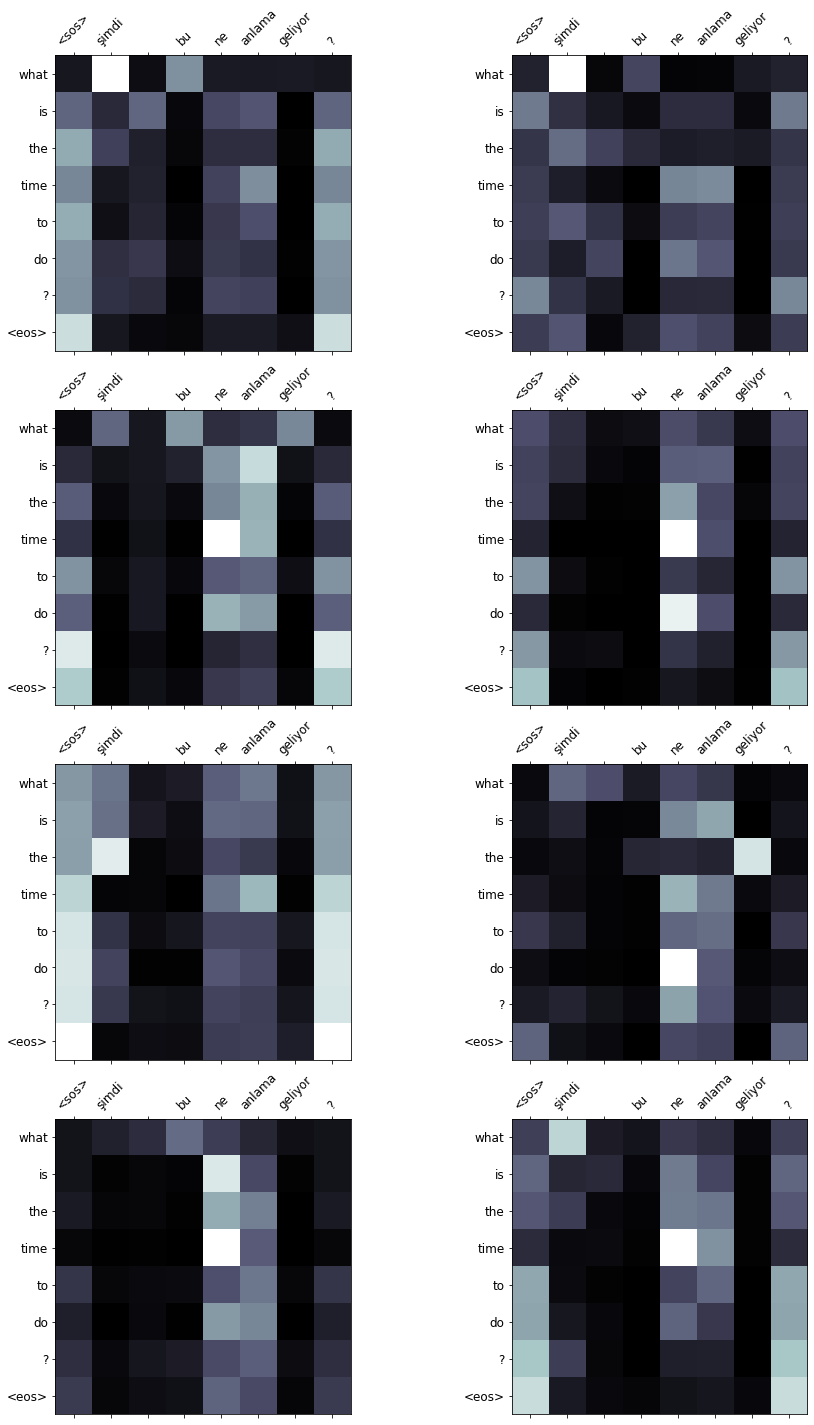

In [34]:
if MODEL_TYPE == 'transformer':
    display_attention(tr_test_preprocessed_text[indx], transcription, attention_mask)

In [47]:
if MODEL_TYPE != 'transformer':
    test_data = [tr_test_preprocessed_text , en_test_preprocessed_text]
    bleu_list = rnn_calculate_bleu(test_data, SRC_FIELD, TRG_FIELD, model, device, MAX_TOKEN_LEN)

    print(f'BLEU1 score = {bleu_list[0] *100:.2f}')
    print(f'BLEU2 score = {bleu_list[1] *100:.2f}')
    print(f'BLEU3 score = {bleu_list[2] *100:.2f}')
    print(f'BLEU4 score = {bleu_list[3] *100:.2f}')

In [33]:
if MODEL_TYPE == 'transformer':
    test_data = [tr_test_preprocessed_text , en_test_preprocessed_text]
    bleu_list, [pred_trgs, trgs] = calculate_bleu(test_data, SRC_FIELD, TRG_FIELD, model, device, MAX_TOKEN_LEN)

    print(f'BLEU1 score = {bleu_list[0] *100:.2f}')
    print(f'BLEU2 score = {bleu_list[1] *100:.2f}')
    print(f'BLEU3 score = {bleu_list[2] *100:.2f}')
    print(f'BLEU4 score = {bleu_list[3] *100:.2f}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


### Evaluate on RNN Based Methods

In [38]:
src.shape, trg.shape

(torch.Size([51, 8]), torch.Size([560]))

In [39]:
load_checkpoint(model, 'model_checkpoints/' + str(MODEL_TYPE) + '_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'model_checkpoints/attention_model.pkl'

In [ ]:
# BLEU SCORE
from torchtext.data.metrics import bleu_score

def get_bleu_batch(gt_trg, pred_trg):
    batch_size = gt_trg.shape[1]

    gt_sentences = []
    pred_sentences = []
    bleu_score_list = []

    for i in range(batch_size):
        gt_sentence   = gt_trg[:, i]
        pred_sentence = pred_trg[:, i, :]

        gt_sentence   = [tr_vocab.itos[token_id] for token_id in gt_sentence]
        # greedy decoding
        pred_sentence = [tr_vocab.itos[torch.argmax(output_distr)] for output_distr in pred_sentence]

        bleu_score = nltk.translate.bleu_score.sentence_bleu([gt_sentence], pred_sentence, weights = [0.5, 0.5])

        gt_sentences.append(gt_sentence)
        pred_sentences.append(pred_sentence)
        bleu_score_list.append(bleu_score)

    return gt_sentences, pred_sentences, bleu_score_list

In [ ]:
test_loss = 0
#evaluate
model.eval()
with torch.no_grad():
    bleu_scores = []
    gt_sentences_list = []
    pred_sentences_list = []

    for _, (src, trg) in enumerate(test_loader):
        src = src.to(device)
        trg = trg.to(device)

        output = model(src, trg, 0) #turn off teacher forcing

        gt_sentences, pred_sentences, bleu_score_list = get_bleu_batch(trg, output)
        bleu_scores.extend(bleu_score_list)
        gt_sentences_list.extend(gt_sentences)
        pred_sentences_list.extend(pred_sentences)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = loss_fn(output, trg)
        test_loss += loss.item()

In [ ]:
indx = 5

In [ ]:
' '.join(gt_sentences_list[indx])

In [ ]:
' '.join(pred_sentences_list[indx])

In [ ]:
test_loss = test_loss / len(test_loader)

In [ ]:
ü-ğprint('Test Loss: {:.3f}, Test PPL: {:7.3f}, Test Bleu: {:.3f}'.format(test_loss, math.exp(test_loss), np.mean(bleu_scores)))